<a href="https://colab.research.google.com/github/hakimozcan/Natural-Language-Processing/blob/main/analyzing_tweets_on_ftx_scandal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This file is an output of a collaborative project.

#Key Themes in Twitter Conversations about Binance post-FTX Scandal

## Import Packages

In [ ]:
#stats
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import cluster
import numpy  as np

#support
import re
import html
import datetime
import os
from os import listdir
from os.path import isfile, join
from pathlib import Path
import json
from os.path import basename
from zipfile import ZipFile
import string
import pickle


#NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from collections import Counter
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import pos_tag
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')
lemmatizer = nltk.stem.WordNetLemmatizer()


import spacy
from spacy.symbols import nsubj, VERB
nlp = spacy.load("en_core_web_sm")

from wordcloud import STOPWORDS, WordCloud, ImageColorGenerator
from matplotlib.font_manager import FontProperties
from matplotlib import cm
from numpy import percentile

#LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim import corpora, models
from gensim.models import Phrases
from gensim.corpora import Dictionary


#Visualisation
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from pprint import pprint

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


## Load Data into Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Explore the Data

In [ ]:
# need to change to filepath in your own computer
#df = pd.read_csv('/content/drive/MyDrive/ftx-binance-tweets-200k (1).csv') #anqi filepath
#df = pd.read_csv('/content/drive/MyDrive/UU ADS/INFOMCDMMC/Data/ftx-binance-tweets-200k.csv') #hamkim filepath
df = pd.read_csv('/content/drive/MyDrive/critical_media/assign2/ftx-binance-tweets-200k.csv')  #fas filepath
df.head()

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,username,user_location,follower_count,id,like_count,quote_count,reply_count,retweet_count,date,tweet
0,CryptoCorvus1,Anywhere Podcasts Roam Free.,188.0,1.613325e+18,0.0,0.0,0.0,0,2023-01-11 23:59:00+00:00,"Heya Cryptozens,\n\nEpisode 429:\nBitvago Reje..."
1,Penthouse_NFT,"Freedom, USA",1372.0,1.613324e+18,35.0,0.0,5.0,2,2023-01-11 23:54:58+00:00,The key is to keep buying in a market downturn...
2,htomi_027,NaN,87.0,1.613323e+18,2.0,0.0,1.0,0,2023-01-11 23:53:44+00:00,1/ Today I would like to share some own though...
3,Tarbird_02,NaN,1.0,1.613322e+18,2.0,0.0,0.0,0,2023-01-11 23:50:04+00:00,Took just 4 minutes to arrive in my wallet. So...
4,Binance_1tader,United States,573.0,1.613318e+18,0.0,0.0,0.0,0,2023-01-11 23:31:24+00:00,Miami-Dade gains right to remove FTX name from...


In [ ]:
# Find how many rows and columns there are in a dataframe.
df.shape

(199273, 10)

 Create a timeline of tweets over months

In [ ]:
# First, convert the 'created_at' column (string date-time) to datetime, with errors set to 'coerce'
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Find rows with 'NaT' values
mask = df['date'].isna()

# Delete rows with 'NaT' values
df = df.dropna(subset=['date'])

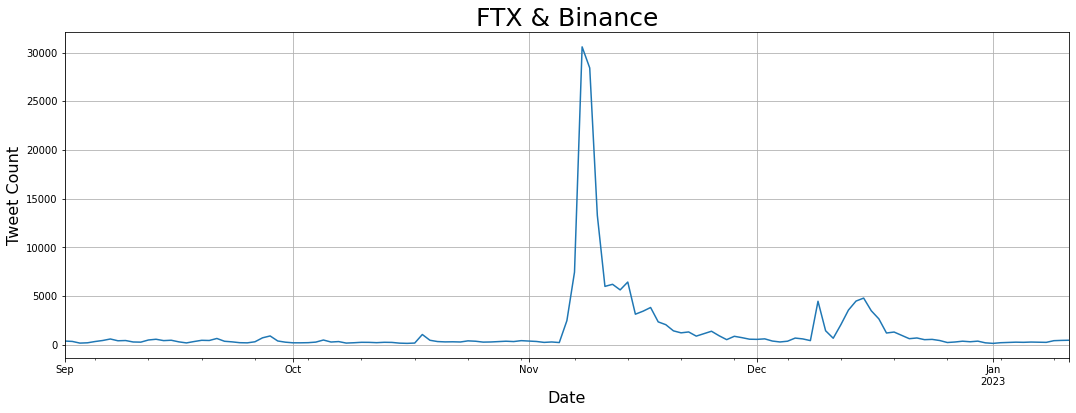

In [ ]:
# Second, create a line graph for tweets per D
tweets_time = df.groupby(pd.Grouper(key='date', freq='D', convention='start')).size()
tweets_time.plot(figsize=(18,6))

plt.rc('axes', titlesize=25)     # fontsize of the axes title
plt.rc('axes', labelsize= 16)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)

plt.ylabel('Tweet Count')
plt.xlabel('Date')
plt.title('FTX & Binance')
plt.grid(True)

Find out how many tweets were posted each day during the first 20 days of November 2022, which is when the most tweets were posted according to the preceding plot.

In [ ]:
# This codeblock needs the previous two codeblocks to be run

# Convert datetime object into the format of YYYY-MM-DD
df['date'] = df['date'].dt.date

df['date'] = pd.to_datetime(df['date'])
start_date = '2022-11-01'
end_date = '2022-11-20'

# Filter the dataframe for tweets within the specified date range
filtered_df = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

# Group the filtered dataframe by date and count the number of tweets per day
tweets_per_day = filtered_df.groupby(filtered_df['date'].dt.date).size()

print(tweets_per_day)

date
2022-11-01      388
2022-11-02      349
2022-11-03      254
2022-11-04      297
2022-11-05      238
2022-11-06     2488
2022-11-07     7465
2022-11-08    30584
2022-11-09    28418
2022-11-10    13286
2022-11-11     6001
2022-11-12     6215
2022-11-13     5641
2022-11-14     6448
2022-11-15     3148
2022-11-16     3453
2022-11-17     3835
2022-11-18     2359
2022-11-19     2070
2022-11-20     1439
dtype: int64


Generate frequencies for hashtags and displays the most frequent 30 hashtags in a word cloud.



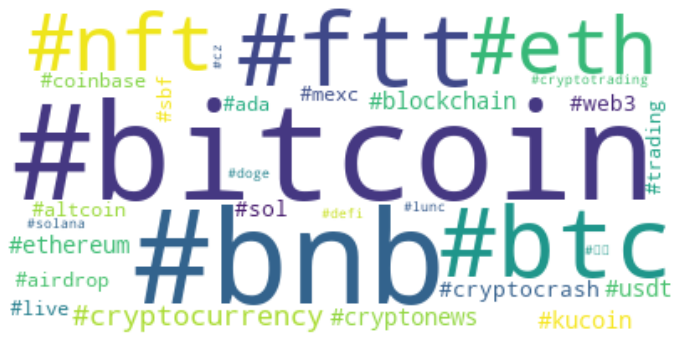

In [ ]:
# Count the number of occurrences of each hashtag in the 'tweet' column, after converting the text to lowercase
hashfreq= df['tweet'].str.lower().str.findall(r'(#\w+)').explode().value_counts()

# Customize the color scheme and set the maximum number of words
wc = WordCloud(
    background_color='#fff',
    max_words=30,
    stopwords=STOPWORDS
)
wc.generate_from_frequencies(hashfreq[3:])

# Adjust the size of the figure
plt.figure(figsize=(12,8))

# Show the word cloud
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

## Mainstream Media analysis

The following code conducts an Mainstream Media analysis, where we consider the top 300 tweeters as our Mainstream Media in determining the discussion about Binance following the FTX scandal. However, in Mainstream Media analysis, looking at engagement metrics (like likes, retweets, replies, quotes) in addition to follower count can help identify and avoid data falsification. Looking at both follower count and engagement metrics together can provide a more accurate picture of an Mainstream Media's true influence and prevent drawing false conclusions.

In [ ]:
# First, create a copy of the original dataframe
newdf = df.copy()


# Next, convert the follower count and engagement columns to numeric data types, and handle any errors that may occur
newdf['follower_count']=pd.to_numeric(newdf['follower_count'], errors='coerce')
newdf['like_count']=pd.to_numeric(newdf['like_count'], errors='coerce')
newdf['quote_count']=pd.to_numeric(newdf['quote_count'], errors='coerce')
newdf['reply_count']=pd.to_numeric(newdf['reply_count'], errors='coerce')
newdf['retweet_count']=pd.to_numeric(newdf['retweet_count'], errors='coerce')

# Create a new column 'combination' that contains the sum of the engagement columns
newdf['combination'] = newdf.loc[:,['like_count','reply_count','retweet_count','quote_count']].sum(axis=1)

# Sort the dataframe by follower count in descending order and select the top 300 rows
newdf_sort=newdf.sort_values(by='follower_count',ascending=False).head(300)

print(newdf_sort.shape)

(300, 11)


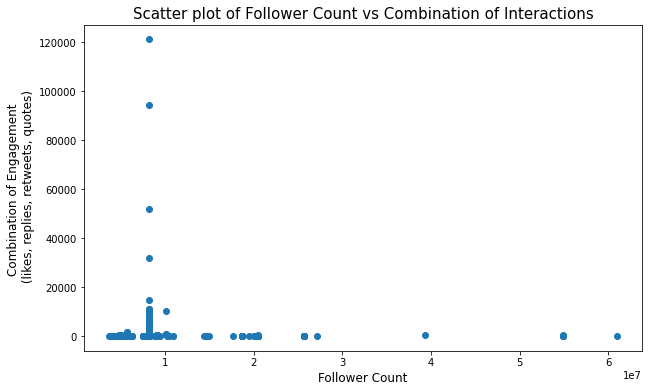

In [ ]:
# Plot the data
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(x = 'follower_count', y = 'combination', data=newdf_sort)


# Set the x-label and y-label
ax.set_xlabel('Follower Count', fontsize=12)
ax.set_ylabel('Combination of Engagement \n (likes, replies, retweets, quotes)', fontsize=12)

# Set the title and adjust its font size to fit the width of the plot
ax.set_title('Scatter plot of Follower Count vs Combination of Interactions', fontsize=15)

plt.show()

In [ ]:
# Looking at the filtered data set, we can see that the mainstream media outlets are dominating the discussion around binance in post-ftx scandal
newdf_sort.username.value_counts()

business           56
CNBC               36
Reuters            33
cz_binance         33
MarketWatch        30
TechCrunch         14
Forbes             12
WSJ                10
EconomicTimes       9
FinancialTimes      6
CoinMarketCap       5
BusinessInsider     5
nytimes             4
the_hindu           4
IndiaToday          3
FT                  3
binance             3
channelstv          3
ABSCBNNews          2
CBSNews             2
Bitcoin             2
guardian            2
barstoolsports      2
washingtonpost      2
guardiannews        2
ANCALERTS           2
MobilePunch         1
eNCA                1
CNN                 1
SkyNews             1
NBCNews             1
WIRED               1
TimesNow            1
cnni                1
timesofindia        1
BBCNews             1
ndtv                1
TIME                1
TheEconomist        1
BBCWorld            1
inquirerdotnet      1
Name: username, dtype: int64

The graph shows that there are many outliers in the relationship between follower count and engagement (likes, comments, etc.). These outliers may be caused by data falsification. Since the distribution of follower counts and engagement does not match a normal distribution, the Standard Deviation Method is not an appropriate way to remove outliers. A better approach is to use the Interquartile Range Method, which identifies and removes outliers by looking at the difference between the 75th and 25th percentiles of the data. This method is more robust to data falsification, as it considers the entire dataset.

In [ ]:
# Create a new column 'coefficient' that normalizes the relationship between 'combination' and 'follower_count' columns by dividing the former by the latter
newdf_sort['coefficient']=newdf_sort['combination']/newdf_sort['follower_count']

# Sort the dataframe by 'coefficient' in descending order and returns the top 5 values
newdf_sort.sort_values(by='coefficient',ascending=False).head()

# Calculate interquartile range
q25,q75 = percentile(newdf_sort['coefficient'], 25), percentile(newdf_sort['coefficient'], 75) # calculates the 25th and 75th percentiles of 'coefficient'

iqr = q75 - q25 # calculates the interquartile range
print('Percentiles: 25th=%.6f, 75th=%.6f, IQR=%.6f' % (q25, q75, iqr)) # prints the percentiles and the interquartile range

# Calculate the outlier cutoff
cut_off = iqr * 1.5 # calculates the cut-off point for identifying outliers
lower, upper = q25 - cut_off, q75 + cut_off # calculates the lower and upper bounds for identifying outliers

# Identify outliers
outliers = [x for x in newdf_sort['coefficient'] if x < lower or x > upper] # creates a list of outliers using the lower and upper bounds
print('Identified outliers: %d' % len(outliers)) # prints the number of identified outliers

# Remove outliers
outliers_removed = [x for x in newdf_sort['coefficient'] if x >= lower and x <= upper] # creates a list of non-outliers using the lower and upper bounds
print('Non-outlier observations: %d' % len(outliers_removed)) # prints the number of non-outlier observations

Percentiles: 25th=0.000003, 75th=0.000015, IQR=0.000013
Identified outliers: 49
Non-outlier observations: 251


(251, 12)

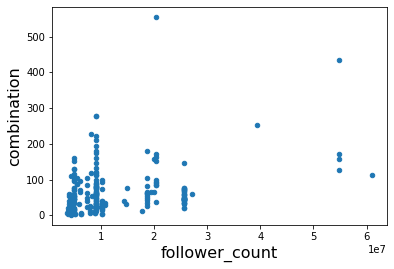

In [ ]:
# Create a lambda function that checks if a value is in the list of non-outlier observations
mylambda = lambda x: x in outliers_removed

# Filter the dataframe to only include rows where the 'coefficient' column passes the lambda function
newdf_sort = newdf_sort.loc[newdf_sort['coefficient'].apply(mylambda)]

# Create a scatter plot of the filtered data, showing the relationship between 'follower_count' and 'combination' columns
# The plot should look better now that outliers have been removed
newdf_sort.plot.scatter(x = 'follower_count', y = 'combination')

# Display the shape of the filtered dataframe
newdf_sort.shape

## Clean the Data

In [ ]:
# Assigns the dataframe 'newdf_sort' to a new variable 'df_new'
df_new = newdf_sort

In [ ]:
# Function for NLP for separating features (Spacy)
def do_nlp(x):
    doc = nlp(x)
    return doc

# Apply the 'do_nlp' function to the 'tweet' column and store the result
df_new['text_nlp'] = df_new['tweet'].apply(lambda x: do_nlp(x))
df_new.head()

,username,user_location,follower_count,id,like_count,quote_count,reply_count,retweet_count,date,tweet,combination,coefficient,text_nlp
51136,CNN,NaN,60956244.0,1.594998e+18,64.0,3.0,32.0,15.0,2022-11-22,Singapore’s central bank has responded to crit...,114.0,0.000002,"(Singapore, ’s, central, bank, has, responded,..."
147131,nytimes,New York City,54857871.0,1.590040e+18,76.0,5.0,21.0,25.0,2022-11-08,"Binance, the world’s largest cryptocurrency ex...",127.0,0.000002,"(Binance, ,, the, world, ’s, largest, cryptocu..."
111608,nytimes,New York City,54857790.0,1.590453e+18,265.0,33.0,42.0,94.0,2022-11-09,Breaking News: The cryptocurrency exchange Bin...,434.0,0.000008,"(Breaking, News, :, The, cryptocurrency, excha..."
38892,nytimes,New York City,54857001.0,1.601185e+18,106.0,1.0,30.0,36.0,2022-12-09,"""The more damage you do now, the more jail tim...",173.0,0.000003,"("", The, more, damage, you, do, now, ,, the, m..."
30439,nytimes,New York City,54856970.0,1.602468e+18,85.0,7.0,33.0,33.0,2022-12-13,"The CEO of Binance, the world’s largest crypto...",158.0,0.000003,"(The, CEO, of, Binance, ,, the, world, ’s, lar..."


The following code extracts verbs, proper nouns, nouns and adjectives from the given tweets. These text features often convey important information about the content and tone of the message. For example, verbs often indicate actions or states of being, proper nouns often refer to specific people or organizations, nouns provide the main subjects or objects of a sentence, and adjectives describe or modify the nouns. By focusing on these parts of speech, we aim to extract the most relevant and informative words and phrases about Binance in the aftermath of ftx scandal, which can be useful for topic modeling and sentiment analysis implemented in the following sections.

In [ ]:
# Function to filter the text to only include selected part-of-speech (POS) tags 'VERB', 'PROPN', 'NOUN' and 'ADJ'
def include_features(x):
    include_features = ['VERB', 'PROPN', 'NOUN', 'ADJ']
    text = ' '.join([ent.text for ent in x if ent.pos_ in include_features])
    return text

# Apply the 'include_features' function
df_new['features'] = df_new['text_nlp'].apply(lambda x: include_features(x))
df_new['features'].head(5)

51136     Singapore central bank responded criticism tre...
147131    Binance world largest cryptocurrency exchange ...
111608    Breaking News cryptocurrency exchange Binance ...
38892     more damage do more jail time Changpeng Zhao c...
30439     CEO Binance world largest cryptocurrency excha...
Name: features, dtype: object

The following code cleans tweets, removing URLs, mentions, numbers, hashtag symbols, and the abbreviation "rt", punctuations, specific words and tokenizes and lemmatizes the text. It also defines and removes a list of stopwords from the text.The code uses the word_tokenize(), lemmatiztion function from the Natural Language Toolkit (nltk) library and other methods.

In [ ]:
# Function to clean the text
def clean_text(x):
    x = x.lower()
    x = re.sub(r'(http|https)://\S+|@\w+|\d+|#(\w+)|rt', '',x) #remove URLs, @-mentions, numbers, #hashtag symbol and the abbreviation "rt"
    x = x.translate(str.maketrans('', '', string.punctuation)) #remove punctuations
    return x



# Apply the 'clean_text' function
df_new['features'] = df_new['features'].apply(lambda x: clean_text(x))
df_new.head()

,username,user_location,follower_count,id,like_count,quote_count,reply_count,retweet_count,date,tweet,combination,coefficient,text_nlp,features
51136,CNN,NaN,60956244.0,1.594998e+18,64.0,3.0,32.0,15.0,2022-11-22,Singapore’s central bank has responded to crit...,114.0,0.000002,"(Singapore, ’s, central, bank, has, responded,...",singapore central bank responded criticism tre...
147131,nytimes,New York City,54857871.0,1.590040e+18,76.0,5.0,21.0,25.0,2022-11-08,"Binance, the world’s largest cryptocurrency ex...",127.0,0.000002,"(Binance, ,, the, world, ’s, largest, cryptocu...",binance world largest cryptocurrency exchange ...
111608,nytimes,New York City,54857790.0,1.590453e+18,265.0,33.0,42.0,94.0,2022-11-09,Breaking News: The cryptocurrency exchange Bin...,434.0,0.000008,"(Breaking, News, :, The, cryptocurrency, excha...",breaking news cryptocurrency exchange binance ...
38892,nytimes,New York City,54857001.0,1.601185e+18,106.0,1.0,30.0,36.0,2022-12-09,"""The more damage you do now, the more jail tim...",173.0,0.000003,"("", The, more, damage, you, do, now, ,, the, m...",more damage do more jail time changpeng zhao c...
30439,nytimes,New York City,54856970.0,1.602468e+18,85.0,7.0,33.0,33.0,2022-12-13,"The CEO of Binance, the world’s largest crypto...",158.0,0.000003,"(The, CEO, of, Binance, ,, the, world, ’s, lar...",ceo binance world largest cryptocurrency excha...


In [ ]:
# it wolud be better to lemmatize by tagging each words' pos and then lemmatize.
# And you can see this function more detail on url:https://www.guru99.com/pos-tagging-chunking-nltk.html
# Get the POS of words
def get_wordnet_pos(tag):
    # adjective words
    if tag.startswith('J'):
        return wordnet.ADJ
    # verbs words
    elif tag.startswith('V'):
        return wordnet.VERB
    # noun. words
    elif tag.startswith('N'):
        return wordnet.NOUN
    #adverb words
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

# this function use for lemmatization
def more_lemmatization(x):
  x = word_tokenize(x)
  tagged_sent = pos_tag(x)
  lemmas_sent = []
  for tag in tagged_sent:
    wordnet_pos = get_wordnet_pos(tag[1]) or wordnet.NOUN #when get_wordnet_pos function return "none", set to wordnet.NOUN
    lemmas_sent.append(lemmatizer.lemmatize(tag[0], pos=wordnet_pos)) # lemmatization
  x=' '.join(lemmas_sent) # tranfer list to string
  return x

# after performing lemmatization and previous step would remain noisy character and then remove them, also  remove stopwprds in this step
def clean_more(x):
  x = nltk.word_tokenize(x) #tokenize
  x =' '.join( [token for token in x if token not in stopwords])#remove stopwords and use join function to make word not tokenize
  x = re.sub(r'\bu\b|’', '',x)  #remove two specific string "u" and "’", which commonly occur in tweets but not removed in the previous steps.
  return x

# Define the list of stopwords to be removed from the text. The NLTK library's English stopwords list is used as the base list.
stopwords = nltk.corpus.stopwords.words('english')
# Additional stopwords specific to this dataset are added. These words appear commonly in all tweets and thus are not distinguishing.
new_sw = ['zhao','changpeng', 'cz', 'bankman','sam','fried','ceo','crypto','exchange','cryptocurrency', "people", "world", "major",'say','day','fry','non','ftt','saga']
stopwords.extend(new_sw)

df_new['features'] = df_new['features'].apply(lambda x: more_lemmatization(x))
df_new['features'] = df_new['features'].apply(lambda x: clean_more(x))

In [ ]:
tweet = df_new['features'].copy()
tweet = tweet.reset_index()
tweet['features'] = tweet['features'].apply(word_tokenize) # tokenize the words because the word hasn't been tokenized
tweet.head()

,index,features
0,51136,"[singapore, central, bank, respond, criticism,..."
1,147131,"[binance, large, buy, rival, company, ftx, fea..."
2,111608,"[break, news, binance, pull, deal, save, rival..."
3,38892,"[damage, jail, time, chief, executive, binance..."
4,30439,"[binance, large, describe, regulation, risk, c..."


In [ ]:
#to check the output whether has been cleaned data successfully before starting next stage. so save to a new file to check
tweet.to_csv('/content/sample_data/checkuExistence.csv')

## LDA based on tweets from Mainstream Media after outliers are removed

In [ ]:
#Function for calculating coherence scores
def coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print('Calculating for',num_topics,'topics')
        model = LdaModel(corpus=corpus, num_topics=num_topics)
        model_list.append(model)

        # Compute coherence score. We tried 'u_mass', 'c_uci'，'c_v' and 'c_npmi' metrics but 'c_uci' seemed more reliable and consistent for our data.
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_uci')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values


# Create dictionary
id2word = corpora.Dictionary(tweet['features'])

# With 251 tweets you can set the no_below=5, no_above=0.8 as a start and adjust accordingly.
# Filter out words that occur in less than 5 tweets or more than 80% of the tweets.
id2word.filter_extremes(no_below=5, no_above=0.8)  # <---------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Create corpus
corpus = [id2word.doc2bow(doc) for doc in tweet['features']]

start = 5
limit = 10
step = 1

model_list, coherence_values = coherence_values(dictionary=id2word, corpus=corpus, texts=tweet['features'], start=start, limit=limit, step=step)

Calculating for 5 topics


Calculating for 6 topics


Calculating for 7 topics


Calculating for 8 topics


Calculating for 9 topics


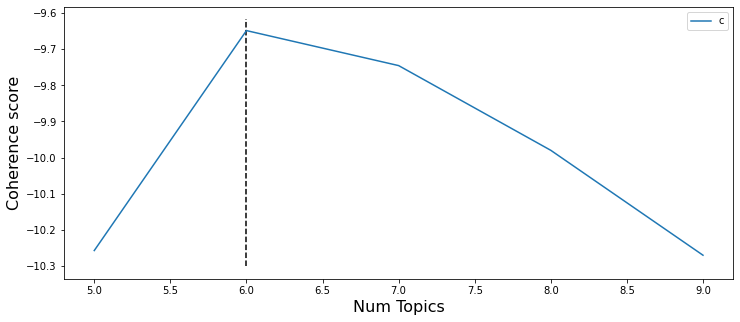

In [ ]:
#Visualise the coherence scores in a plot.
x = range(start, limit, step)
plt.figure(figsize=(12,5))
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.vlines(x[np.argmax(coherence_values)], plt.ylim()[0], plt.ylim()[1],linestyles='dashed')
plt.show()

In [ ]:
# List the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 5  has Coherence Value of -10.2569
Num Topics = 6  has Coherence Value of -9.6487
Num Topics = 7  has Coherence Value of -9.7455
Num Topics = 8  has Coherence Value of -9.9797
Num Topics = 9  has Coherence Value of -10.2698


In [ ]:
# Apply LDA model
model = LdaModel(corpus=corpus, num_topics=6, id2word=id2word)
model.print_topics(num_words=20)

[(0,
  '0.064*"rival" + 0.051*"late" + 0.047*"acquire" + 0.043*"token" + 0.038*"plan" + 0.034*"large" + 0.034*"investor" + 0.030*"collapse" + 0.030*"founder" + 0.026*"follow" + 0.022*"bailout" + 0.020*"acquisition" + 0.018*"platform" + 0.017*"sell" + 0.017*"top" + 0.017*"mean" + 0.017*"fallout" + 0.017*"bitcoin" + 0.016*"bail" + 0.013*"price"'),
 (1,
  '0.101*"rival" + 0.035*"buy" + 0.033*"deal" + 0.031*"acquisition" + 0.030*"asset" + 0.028*"collapse" + 0.028*"acquire" + 0.025*"chief" + 0.024*"liquidity" + 0.024*"billionaire" + 0.024*"digital" + 0.023*"trading" + 0.019*"company" + 0.018*"sign" + 0.017*"large" + 0.017*"plan" + 0.017*"come" + 0.014*"value" + 0.014*"lead" + 0.014*"crunch"'),
 (2,
  '0.071*"deal" + 0.061*"rival" + 0.046*"buy" + 0.038*"firm" + 0.034*"plan" + 0.034*"collapse" + 0.030*"rescue" + 0.027*"chief" + 0.027*"company" + 0.026*"week" + 0.023*"big" + 0.023*"executive" + 0.023*"employee" + 0.019*"cryptocurrencies" + 0.019*"option" + 0.016*"acquire" + 0.016*"industry" + 

## Sentiment Analysis

In [ ]:
# Show the top 20 words of each topic and save as a .csv file

N_TOPICS=6
# Create an empty dictionary to store the top words for each topic
dct = {}
for topic in range(N_TOPICS):
    words = model.show_topic(topic, 20)
    topic_n_words = ' '.join([word[0] for word in words])
    dct['Topic_%s' % topic] = topic_n_words

# Create a DataFrame from the dictionary and save it as a .csv file
df4=pd.DataFrame(dct.items(), columns=['Topic_n', 'Words'])
df4.to_csv("topic_top_words.csv")
df4

,Topic_n,Words
0,Topic_0,rival late acquire token plan large investor c...
1,Topic_1,rival buy deal acquisition asset collapse acqu...
2,Topic_2,deal rival buy firm plan collapse rescue chief...
3,Topic_3,buy rival deal liquidity crunch cover collapse...
4,Topic_4,collapse industry wake chief firm bankruptcy f...
5,Topic_5,buy platform break last follow listen coinbase...


In [ ]:
# Create a DataFrame of topic number and corresponding words from dictionary in order to do sentiment analysis
df3=pd.DataFrame(dct.items(), columns=['Topic_n', 'Words'])

This code uses the SentimentIntensityAnalyzer module to calculate sentiment scores for each row in a dataframe column 'Words'. It then extracts the compound score as a new column and creates a new column 'label' by applying a function that labels sentiment as negative, neutral or positive based on the compound score.

In [ ]:
# Import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Use SentimentIntensityAnalyzer to calculate sentiment scores
df3['score'] = df3['Words'].apply(lambda x: sid.polarity_scores(x))

df3

,Topic_n,Words,score
0,Topic_0,rival late acquire token plan large investor c...,"{'neg': 0.197, 'neu': 0.726, 'pos': 0.077, 'co..."
1,Topic_1,rival buy deal acquisition asset collapse acqu...,"{'neg': 0.127, 'neu': 0.677, 'pos': 0.195, 'co..."
2,Topic_2,deal rival buy firm plan collapse rescue chief...,"{'neg': 0.131, 'neu': 0.735, 'pos': 0.135, 'co..."
3,Topic_3,buy rival deal liquidity crunch cover collapse...,"{'neg': 0.123, 'neu': 0.651, 'pos': 0.226, 'co..."
4,Topic_4,collapse industry wake chief firm bankruptcy f...,"{'neg': 0.144, 'neu': 0.856, 'pos': 0.0, 'comp..."
5,Topic_5,buy platform break last follow listen coinbase...,"{'neg': 0.143, 'neu': 0.807, 'pos': 0.049, 'co..."


In [ ]:
# Extract the compound score as a new column
df3['compound']  = df3['score'].apply(lambda x: x['compound'])
df3

,Topic_n,Words,score,compound
0,Topic_0,rival late acquire token plan large investor c...,"{'neg': 0.197, 'neu': 0.726, 'pos': 0.077, 'co...",-0.4215
1,Topic_1,rival buy deal acquisition asset collapse acqu...,"{'neg': 0.127, 'neu': 0.677, 'pos': 0.195, 'co...",0.1779
2,Topic_2,deal rival buy firm plan collapse rescue chief...,"{'neg': 0.131, 'neu': 0.735, 'pos': 0.135, 'co...",0.0258
3,Topic_3,buy rival deal liquidity crunch cover collapse...,"{'neg': 0.123, 'neu': 0.651, 'pos': 0.226, 'co...",0.4019
4,Topic_4,collapse industry wake chief firm bankruptcy f...,"{'neg': 0.144, 'neu': 0.856, 'pos': 0.0, 'comp...",-0.4939
5,Topic_5,buy platform break last follow listen coinbase...,"{'neg': 0.143, 'neu': 0.807, 'pos': 0.049, 'co...",-0.4767


In [ ]:
# Function to label sentiment as negative, neutral, or positive based on compound score
def labelfunction(x):
    if x <-0.05:
        return 'Negative'
    elif x > 0.05:
        return 'Positive'
    else:
        return 'Neutral'

# Apply the label function to the compound column to create a new 'label' column
df3['label'] = df3['compound'].apply(lambda x: labelfunction(x))
df3

,Topic_n,Words,score,compound,label
0,Topic_0,rival late acquire token plan large investor c...,"{'neg': 0.197, 'neu': 0.726, 'pos': 0.077, 'co...",-0.4215,Negative
1,Topic_1,rival buy deal acquisition asset collapse acqu...,"{'neg': 0.127, 'neu': 0.677, 'pos': 0.195, 'co...",0.1779,Positive
2,Topic_2,deal rival buy firm plan collapse rescue chief...,"{'neg': 0.131, 'neu': 0.735, 'pos': 0.135, 'co...",0.0258,Neutral
3,Topic_3,buy rival deal liquidity crunch cover collapse...,"{'neg': 0.123, 'neu': 0.651, 'pos': 0.226, 'co...",0.4019,Positive
4,Topic_4,collapse industry wake chief firm bankruptcy f...,"{'neg': 0.144, 'neu': 0.856, 'pos': 0.0, 'comp...",-0.4939,Negative
5,Topic_5,buy platform break last follow listen coinbase...,"{'neg': 0.143, 'neu': 0.807, 'pos': 0.049, 'co...",-0.4767,Negative


The following code generates word cloud visualizations for each topic in a dataframe.

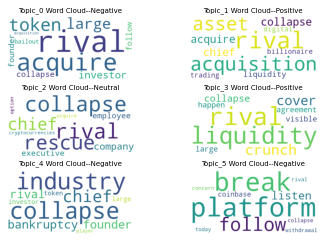

In [ ]:
# Get stopwords from wordcloud library
stopwords = set(STOPWORDS)

# Add additional stopwords as needed for our purpose
extra_stopwords = []
stopwords.update(extra_stopwords)

# Set font size for title
font = FontProperties()
font.set_size(7)

# Combine all wordcloud into a figure (3 rows x 2 columns)
fig, axes = plt.subplots(3, 2)

# Loop through each topic in the dataframe
for i in range(len(df3)):
    # Get the text and label of the topic
    text = df3.loc[i]['Words']
    label=df3.loc[i]['label']
    wordcloud= WordCloud(stopwords=stopwords, background_color="white", max_words=10, min_word_length=5).generate(text)
    wc_array = np.array(wordcloud)
    if i < 6:
        # show each topic as a seperate wordcloud
        axes[i // 2, i % 2].imshow(wc_array, cmap='gray')
        # remove axis legend and add title
        axes[i // 2, i % 2].axis("off")
        axes[i // 2, i % 2].set_title(f'Topic_{i} Word Cloud--{label} ',fontproperties=font)
    else:
        break

# Save the picture and set the resolution as 300
plt.savefig("wordcloud_comb.png",dpi=300)
# Show the combined wordclouds
plt.show()

The code below will show the word cloud separately for each topic. The title of each plot shows the topic number and the label of the topic, which is either negative, neutral or positive. The words are filtered by the stopwords list and some ad-hoc words, and the min word length is set to be 5. Also the image is saved as png file for each iteration.

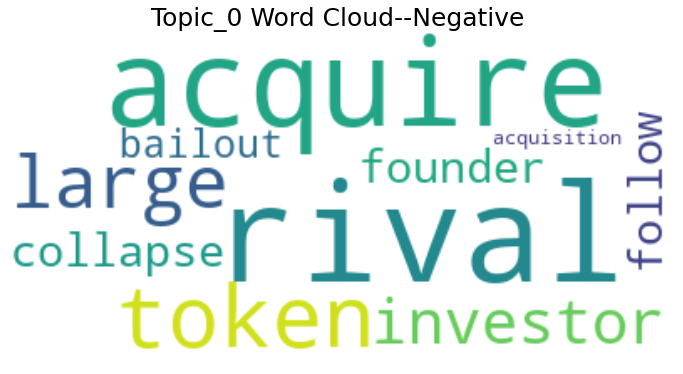

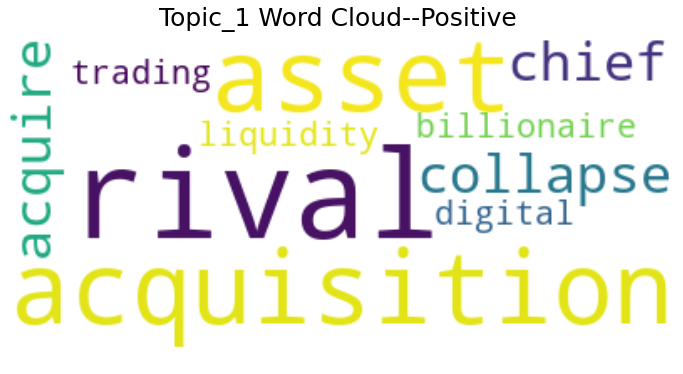

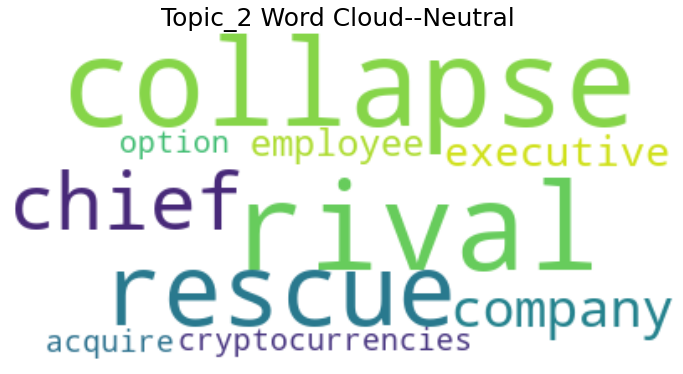

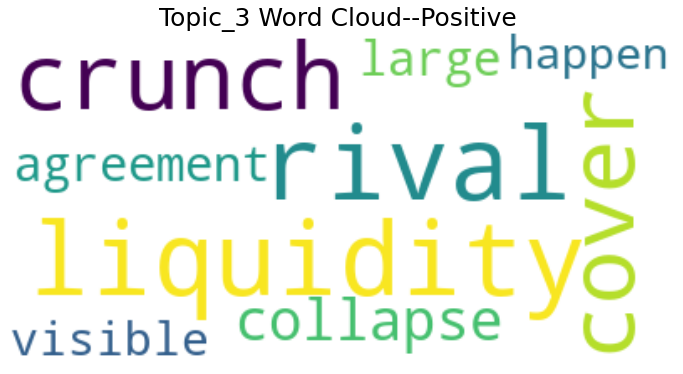

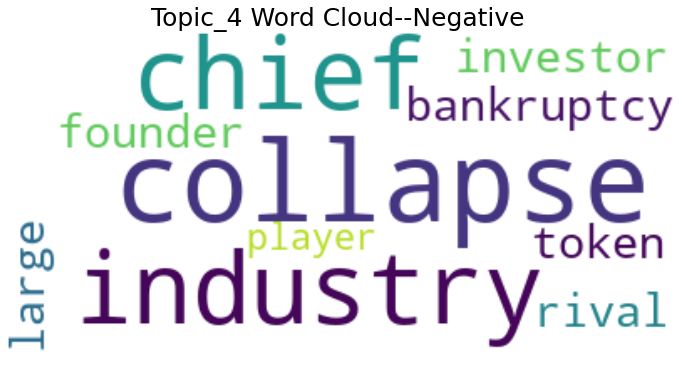

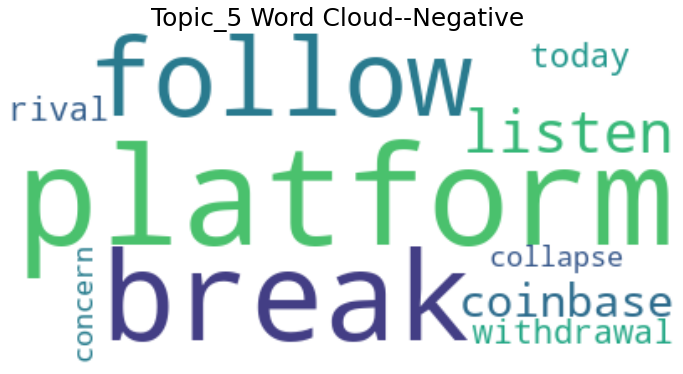

In [ ]:
# Word cloud  for a loop , show the word cloud seperately

# Get stopwords from wordcloud library
stopwords = set(STOPWORDS)

# Add some extra words ad hoc for our purpose
extra_stopwords = []
stopwords.update(extra_stopwords)

# Iterate over the dataframe and generate a wordcloud for each topic
for i in range(len(df3)):
  text = df3.loc[i]['Words']
  label=df3.loc[i]['label']

  # Generate the image
  wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=10, min_word_length=5).generate(text) # <--------------------------------------------------------------------------------------------------------------
  plt.figure(figsize=(12, 8))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off")
  plt.title(f'Topic_{i} Word Cloud--{label} ')
  plt.savefig(f'wordcloud{i}.png')  # save as png file
  plt.show()